In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import h5py
import sys
sys.path.insert(0, '/Users/landerson/dust-map/src/experiments')
from experiments import experiment_util as eu
import torch
from ziggy import svgp
import yt
from yt.units import kpc, kiloparsec, Msun 
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator as NDInterp

import matplotlib.pyplot as plt; plt.ion()
import seaborn as sns; sns.set_style("white")
from ziggy import viz
import os

In [3]:
def genDustDensity(nx, ny, nz, xscale, yscale, zscale):

    x = np.linspace(-xscale, xscale+0.00001, nx)
    y = np.linspace(-yscale, yscale+0.00001, ny)
    z = np.linspace(-zscale, zscale+0.00001, nz)
    
    xmesh, ymesh, zmesh = np.meshgrid(x, y, z)
    xdustgrid = np.column_stack([xmesh.flatten(), ymesh.flatten(), zmesh.flatten()])
    
    left_edge = [-xscale, -yscale, -zscale]*kpc
    right_edge = [xscale, yscale, zscale]*kpc
    ag = ds.arbitrary_grid(left_edge, right_edge, dims=[nx, ny, nz])
    
    dustDensity = ag[('io', 'dustDensity')]

    return xmesh, ymesh, zmesh, xdustgrid, dustDensity

def ftestValues(xtest, xscale, yscale, zscale, nx=50, ny=None, nz=25):
    if ny is None: ny = nx
    x, y, z, xdustgrid, dustDensity = genDustDensity(nx, ny, nz, xscale, yscale, zscale)
    dustgrid = dustDensity.flatten()
    interp = NDInterp(xdustgrid, dustgrid)
    return interp(xtest)

In [4]:
from yt.units import dimensions
def _metal_weighted_density(field, data):
    solarMetallicity = 0.2
    massfraction_he = data['massfraction_he']
    massfraction_all  = data['massfraction_all']
    fractionHydrogen = 1. - massfraction_all - massfraction_he
    neutralHydrogenMass = data['density']*fractionHydrogen*data['hydrogen_neutral_fraction']
    metalWeightedNeutralHydrogenMass = neutralHydrogenMass*10.**data['metallicity']
    return metalWeightedNeutralHydrogenMass

yt.add_field(("io","dustDensity"), function=_metal_weighted_density, units='Msun/pc**3', #units="auto", 
             dimensions=dimensions.density, sampling_type='particle', force_override=True)

In [5]:
def plot_grid(model_name, fgrid, xobs, aobs, n, pretty_name=None,
                        xx1=None, xx2=None, vmin=None, vmax=None):
    """ Visualize posteiror grid slice
    """
    # model name is model directory
    if pretty_name is None:
        pretty_name = os.path.split(model_name)[-1]

    # error DF for dists
    df = eu.make_error_dataframe([model_name], [pretty_name])
    pdict = torch.load(os.path.join(model_name, "predictions.pkl"))
    mdict = torch.load(os.path.join(model_name, "model.pkl"))
    print("Kernel params! ", torch.exp(mdict['kernel_params']))

    # plot posterior mean on xgrid
    (xlo, xhi) = xx1.min(), xx1.max()
    (ylo, yhi) = xx2.min(), xx2.max()
    fig, axes = plt.subplots(2, 4, figsize=(16,9))
    
    ax = axes[0, 0]
    cm = viz.plot_smooth(ax, fgrid, xlim=(xlo, xhi), ylim=(xlo, xhi), vmin=vmin, vmax=vmax)
    ax.set_xlim(xlo, xhi)
    ax.set_ylim(ylo, yhi)
    ax.set_title('Truth')
    
    ax = axes[0, 1]
    im = ax.scatter(xobs[:,0], xobs[:,1], c=aobs, s=10, vmin=vmin, vmax=vmax)
    viz.colorbar(im, ax)
    ax.axis('equal')
    ax.set_xlim(xlo, xhi)
    ax.set_ylim(ylo, yhi)
    ax.set_title('Observations')

    
    
    ax = axes[1,0]
    cm = viz.plot_smooth(ax, pdict['fmu_grid'].reshape(xx1.shape)[:, :, n],
                         xlim=(xlo, xhi), ylim=(xlo, xhi),
                         vmin=vmin, vmax=vmax)
    ax.set_xlim(xlo, xhi)
    ax.set_ylim(ylo, yhi)
    ax.set_title('Prediction')

    ax = axes[1, 1]
    cm = viz.plot_smooth(ax, 2*pdict['fsig_grid'].reshape(xx1.shape)[:, :, n],
                         xlim=(xlo, xhi), ylim=(xlo, xhi))
    ax.set_xlim(xlo, xhi)
    ax.set_ylim(ylo, yhi)
    ax.set_title(r'$\sigma$')
   
    """ make plots that show error as a function of distance """

    # for zscore, show 1/2 sd, 1 sd, and 2 sd
    error_types = ["e zscore", "f zscore"]
    for error_type, ax in zip(error_types, [axes[0, 2], axes[1,2]]):

        xlo, xhi = df['xtest_dist'].min(), df['xtest_dist'].max()
        for sig in [.5, 1., 2.]:
            ax.plot([xlo, xhi], [sig, sig], '--', linewidth=1.5, c='grey')
            ax.plot([xlo, xhi], [-sig, -sig], '--', linewidth=1.5, c='grey')
            ax.fill_between([xlo, xhi], [sig, sig], [-sig, -sig], color='grey', alpha=.2)

        ax.scatter(df['xtest_dist'], df[error_type], s=15)
        ax.set_xlabel("distance", fontsize=12)
        ax.set_ylabel(error_type, fontsize=12)
        
    for error_type, ax in zip(error_types, [axes[0, 3], axes[1, 3]]):

        ax.hist(df[error_type], bins=30, density=True, alpha=.5, label=pretty_name)

        from scipy.stats import norm
        xlim = ax.get_xlim()
        xgrid = np.linspace(-5, 5, 100)
        #ax.set_xlim(-5, 5)
        ax.plot(xgrid, norm.pdf(xgrid), label="$\mathcal{N}(0,1)$")

        ax.set_xlabel("z score", fontsize=12)
        ax.set_ylabel("density", fontsize=12)
        ax.legend(fontsize=12, frameon=True, loc='upper left')

    plt.tight_layout()
    fig.savefig(os.path.join(model_name, 'plot_grid.pdf'), bbox_inches='tight', rasterized=True)

In [6]:
latte = np.load('latte10kpc.npz')
f = h5py.File('distance1kpc_snp5_lsr2_m12f.hdf5', mode='r')

In [7]:
Q = 2.5e22 #H/cm2/mag
EBV = 1/3.1
m_p = 1.6726219e-24 #g
length_unit=3.08567758149137e21 #kpc to cm  
mass_unit=1.98847e33 #solar mass to g 
time_unit=3.15576e16 #Gyr to s, 
velocity_unit=1e5 #km to cm   
unit_system="galactic" #'cgs'
sim_time = latte['snapshottime']*time_unit
field = 'io'

In [8]:
data = {(field, 'particle_position_x'): np.array(latte['x'], dtype='float64'),
        (field, 'particle_position_y'): np.array(latte['y'], dtype='float64'),
        (field, 'particle_position_z'): np.array(latte['z'], dtype='float64'),
        (field, 'particle_velocity_x'): np.array(latte['velocity'][:,0], dtype='float64'),
        (field, 'particle_velocity_y'): np.array(latte['velocity'][:,1], dtype='float64'),
        (field, 'particle_velocity_z'): np.array(latte['velocity'][:,2], dtype='float64'),
        (field, 'density'):    np.array(latte['density'], dtype='float64'),
        (field, 'hydrogen_neutral_fraction'): np.array(latte['hydrogenneutralfraction'], dtype='float64'),
        (field, 'massfraction_he'): np.array(latte['massfraction'][:,1], dtype='float64'),
        (field, 'massfraction_all'): np.array(latte['massfraction'][:,0], dtype='float64'),
        (field, 'metallicity'): np.array(latte['metallicitytotal'], dtype='float64'),
        (field, 'smoothing_length'): np.array(latte['smoothlength'], dtype='float64'),
        (field, 'particle_mass'): np.array(latte['mass'], dtype='float64')
        }
half_box = latte['boxlength']/2.*length_unit
bbox = np.array([[-half_box, half_box], [-half_box, half_box], [-half_box, half_box]])

ds = yt.load_particles(data, length_unit=length_unit, mass_unit=mass_unit, velocity_unit=velocity_unit, 
                       time_unit=time_unit, bbox=bbox, unit_system=unit_system, sim_time=sim_time)

yt : [INFO     ] 2019-07-03 17:18:01,167 Parameters: current_time              = 4.3545533462416614e+17
yt : [INFO     ] 2019-07-03 17:18:01,168 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2019-07-03 17:18:01,171 Parameters: domain_left_edge          = [-1.31866563e+26 -1.31866563e+26 -1.31866563e+26]
yt : [INFO     ] 2019-07-03 17:18:01,174 Parameters: domain_right_edge         = [1.31866563e+26 1.31866563e+26 1.31866563e+26]
yt : [INFO     ] 2019-07-03 17:18:01,175 Parameters: cosmological_simulation   = 0.0


In [9]:
xobs_all = np.array((f['data']['px_true'], 
                 f['data']['py_true'], 
                 f['data']['pz_true'])).T
aobs_true = f['data']['A0']*50.

In [10]:
integrated_dust_uncertainty_mean = 0.1
integrated_dust_uncertainty_sig = 0.1
sobs_all = (np.random.rand(*aobs_true.shape)*integrated_dust_uncertainty_sig + integrated_dust_uncertainty_mean)
aobs_all = np.random.randn(*aobs_true.shape)*sobs_all + aobs_true
len(aobs_all)

39226428

In [16]:
scale = 0.5 #kpc
zscale = 0.25 #kpc
ntrain = 100000
ntest = 10000
subsample_size =ntrain + ntest
#print(np.sum(np.all(np.abs(xobs_all) < scale, axis=1)))
#subsample = np.where(np.all(np.abs(xobs_all) < scale, axis=1))[0]
subsample = np.where((np.abs(xobs_all[:,0]) < scale) & (np.abs(xobs_all[:,1]) < scale) & (np.abs(xobs_all[:,2]) < zscale))[0]
subsample = subsample[np.random.randint(0, high=len(subsample), size=subsample_size)]
#subsample = np.random.randint(0, high=len(xobs_all), size=10000)
print(len(subsample))


110000


In [17]:
xobs = xobs_all[subsample[0:ntrain]]
aobs = aobs_all[subsample[0:ntrain]]
sobs = sobs_all[subsample[0:ntrain]]

xtest = xobs_all[subsample[ntrain:]]
etest = aobs_true[subsample[ntrain:]]


In [24]:
nx_induce = 15
nz_induce = 7
xinduce_grid = np.linspace(-scale, scale+0.0000001, nx_induce)
xinduce_zgrid = np.linspace(-zscale, zscale + 0.00000001, nz_induce)
XX, YY, ZZ = np.meshgrid(xinduce_grid, xinduce_grid, xinduce_zgrid)
xinduce = np.column_stack([XX.flatten(), YY.flatten(), ZZ.flatten()])

nx = ny = nx_induce*4
nz = nz_induce*4
xmesh, ymesh, zmesh, xgrid, fgrid = genDustDensity(nx, ny, nz, scale, scale, zscale)

In [25]:
ftest = ftestValues(xtest, scale, scale, zscale, nx=nx, ny=ny, nz=nz)

kernel_rate = 0 means leave kernel to values I set 
turn natgrad_rate down to 0.01 if elbo looks wonky 
if doing 1e6 data points make batch size bigger 
step_decay, after every epoch natgrad_rate multiplied by

In [15]:
xmesh_low, ymesh_low, zmesh_low, xgrid_low, fgrid_low = genDustDensity(nx_induce, nx_induce, nz_induce, scale, scale, zscale)
xmesh_high, ymesh_high, zmesh_high, xgrid_high, fgrid_high = genDustDensity(nx, ny, nz, scale, scale, zscale)

In [16]:
xmesh_low.shape

(10, 10, 5)

NameError: name 'xmesh_low' is not defined

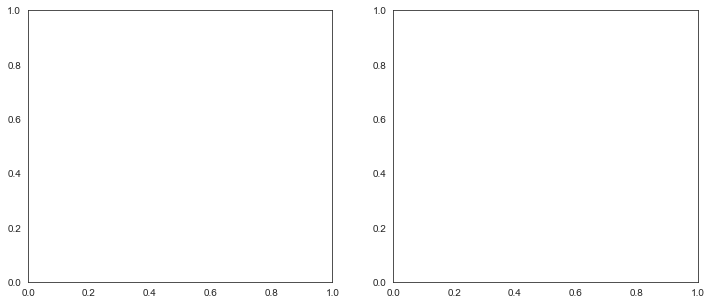

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

ax = axes[0]
n = 2
im = ax.pcolormesh(xmesh_low[:,:,n], ymesh_low[:,:,n], fgrid_low[:,:,n].T)
plt.colorbar(im, ax=ax)

ax = axes[1]
im = ax.pcolormesh(xmesh_high[:,:,n*4], ymesh_high[:,:,n*4], fgrid_high[:,:,n*4].T)
plt.colorbar(im, ax=ax)


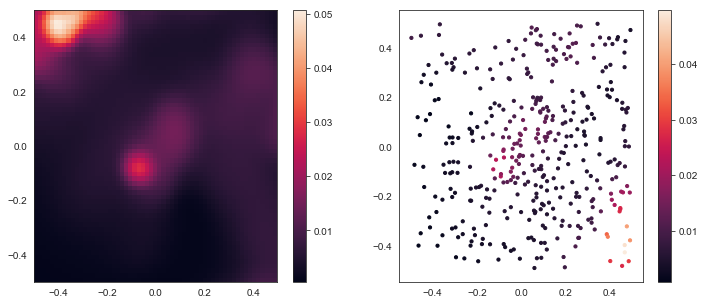

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

ax = axes[0]
n = 10
im = ax.pcolormesh(xmesh[:,:,n], ymesh[:,:,n], fgrid[:,:,n].T)
plt.colorbar(im, ax=ax)

z = np.unique(zmesh[:,:,n])

ax = axes[1]
inslice = np.abs(xtest[:,2] - z) < 0.01
im = ax.scatter(xtest[inslice,0], xtest[inslice,1], c=ftest[inslice], s=10)
plt.colorbar(im, ax=ax)

In [28]:
output_dir = "./monte-carlo-gradient-domainsimulation-output_1kpc"

In [ ]:
fit_kwargs = {'epochs'        : 2,
              'natgrad_rate'  : 1e-1,
              'kernel_rate'   : 0, #1e-6,
              'integrated_obs': True,
              'batch_callback': None, 
              'batch_size'    : 5000,
              'step_decay'    : .9,
              'sig2_init'     : 2,
              'ell_init'      : 0.07}

#########################################################################
# Example: Integrated GP model using Squared Exp Kernel (analytical)    #
#########################################################################
eu.fit_model_and_save("SqExp-analytic",
      xobs=xobs, aobs=aobs[:,None], sobs=sobs[:,None],
      kern=svgp.SqExp(), xinduce=xinduce,
      xtest=xtest, etest=etest, ftest=ftest*50.,
      xgrid=xgrid, fgrid=fgrid*50.,
      output_dir=output_dir,
      **fit_kwargs)


{'epochs': 2, 'natgrad_rate': 0.1, 'kernel_rate': 0, 'integrated_obs': True, 'batch_callback': None, 'batch_size': 5000, 'step_decay': 0.9, 'sig2_init': 2, 'ell_init': 0.07}
 ... [20000/100000 (20%)] ELBO: -8397.813986  (sig2, ell)+grad: (2.00, 0.07) (79.16, -20581.96))
 ... [40000/100000 (40%)] ELBO: -6271.824931  (sig2, ell)+grad: (2.00, 0.07) (80.22, -24361.96))
 ... [60000/100000 (60%)] ELBO: -4730.672758  (sig2, ell)+grad: (2.00, 0.07) (78.94, -18634.39))
 ... [80000/100000 (80%)] ELBO: -3675.472159  (sig2, ell)+grad: (2.00, 0.07) (76.34, -19898.01))
 ... [100000/100000 (100%)] ELBO: -2797.919868  (sig2, ell)+grad: (2.00, 0.07) (78.34, -18594.85))
Epoch     0: -2797.920  (20   batches) 
 ... [20000/100000 (20%)] ELBO: 773.196461  (sig2, ell)+grad: (2.00, 0.07) (79.18, -17498.58))
 ... [40000/100000 (40%)] ELBO: 763.296623  (sig2, ell)+grad: (2.00, 0.07) (80.22, -19468.84))
 ... [60000/100000 (60%)] ELBO: 832.219176  (sig2, ell)+grad: (2.00, 0.07) (78.93, -16792.07))
 ... [80000/10

In [ ]:
model_name = 'monte-carlo-gradient-domainsimulation-output_1kpc/SqExp-analytic'
n=10
z = np.unique(zmesh[:,:,n])
inslice = np.abs(xobs[:,2] - z) < 0.01
plot_grid(model_name, fgrid[:,:,n].value*50., xobs[inslice], aobs[inslice], n, xx1=xmesh, xx2=ymesh,pretty_name='SpExp-analytic')

In [1]:
#eu.plot_posterior_grid(model_name, xx1=xmesh, xx2=ymesh, pretty_name='SpExp-analytic')
eu.make_zscore_histogram(model_name, pretty_name='SpExp-analytic')
eu.make_model_distance_plots(model_name, pretty_name='SpExp-analytic')
eu.make_error_plots(output_dir, model_names=[model_name], pretty_names=['SpExp-analytic'])
eu.make_qq_plots([model_name], pretty_names=['SpExp-analytic'])

NameError: name 'eu' is not defined

In [84]:
predictions = torch.load('monte-carlo-gradient-domainsimulation-output/SqExp-analytic/predictions.pkl')

In [85]:
np.max(predictions['fmu_test'])

41.09804278565571

In [86]:
np.sum(predictions['fmu_test'] == 0)

0

In [87]:
predictions['fmu_test'][predictions['fmu_test'] != 0]

array([ 2.19123823,  2.94589538,  1.71459292, ..., -0.04580047,
       23.59789498,  5.97113618])

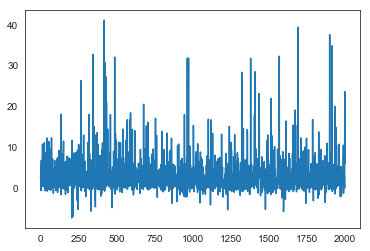

In [88]:
plt.plot(predictions['fmu_test'])


Dataframe objects for a bunch of different kernels, including Sara's with her hyper parameters 
At least 1M observations 

In [11]:
f['data']['px_true']

array([ 0.03735441,  0.03093006, -0.01530889, ..., -0.05356902,
       -0.148144  ,  0.15932871])

In [8]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.iteritems():
        print("    %s: %s" % (key, val))

f.visititems(print_attrs)

data


AttributeError: 'AttributeManager' object has no attribute 'iteritems'